### Analysis Introduction

This analysis focuses on building a machine learning model to predict low birthweight(low_bwght) of babies (defined as bwght < 3430 grams) in newborns. The data exhibited a significant class imbalance, with a much higher proportion of normal birthweight cases. To address this, weight threshold was adjusted to generate a balanced dataset for model training. Feature importance analysis revealed that mother's age (mage) and father's age (fage) had the strongest influence on the model's prediction of birthweight. Evaluating the model's performance revealed a trade-off between accuracy and correctly identifying low birthweight cases (controlled for using False Negatives in the confusion matrix). Given the importance of early intervention for low birthweight babies, the model prioritizes minimizing False Negatives even if it leads to some False Positives. Further optimization efforts could focus on improving the model's overall performance and potentially reduce these classification errors.

### Package and Dataset Imports

In [1]:
# importing libraries
import pandas as pd                                      # data science essentials
import numpy as np                                       # mathematical essentials
import seaborn as sns
import matplotlib.pyplot as plt
import phik                      # phi coefficient
from scipy import stats
from sklearn.linear_model import LinearRegression


# model preparation
from sklearn.preprocessing import power_transform    # yeo-johnson
from sklearn.preprocessing import StandardScaler       # standard scaler
from sklearn.model_selection import train_test_split   # train-test split
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tuning


# model results
from sklearn.metrics import r2_score, mean_squared_error # evaluation metrics
from sklearn.metrics import roc_auc_score              # auc score
from sklearn.metrics import make_scorer                # customizable scorer
from sklearn.metrics import confusion_matrix           # confusion matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# machine learning
import statsmodels.formula.api as smf                   # logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
import warnings                                          # warnings from code

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# suppressing warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
## importing data ##

# reading modeling data into Python
modeling_data = './birthweight.csv'

# calling this df_train
df_train = pd.read_csv(filepath_or_buffer  = modeling_data,
                         header     = 0)
print(f'Training data shape: {df_train.shape}')

# reading testing data into Python
testing_data = './kaggle_test_data.csv'

# calling this df_test
df_test = pd.read_csv(filepath_or_buffer = testing_data,
                        header     = 0)
print(f'Testing data shape: {df_test.shape}')
df_test_index = df_test['obs_id']

Training data shape: (1648, 19)
Testing data shape: (184, 18)


In [3]:
# Create a new column 'low_bwght' such that if it is 1 if bwght < threshold value of 3430
df_train['low_bwght'] = df_train['bwght'].apply(lambda x: 1 if x < 3430 else 0)

# proportion of 1s and 0s for low_bwght
df_train.value_counts(
    subset    = 'low_bwght',
    normalize = True      ).round(decimals = 2).sort_index(ascending = True)

low_bwght
0    0.5
1    0.5
Name: proportion, dtype: float64

In [4]:
# concatenating datasets together for mv analysis and feature engineering
df_train['set'] = 'Not Kaggle'
df_test ['set'] = 'Kaggle'

# concatenating both datasets together for mv and feature engineering
data = pd.concat(objs = [df_train, df_test],
                    axis = 0,
                    ignore_index = False)


# checking data
data.head(n = 5)

,obs_id,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,low_bwght,set
0,id_0001,33,12.0,1.0,5.0,31.0,11.0,NaN,NaN,0.0,0.0,1,1,0,0,1,0,0,360.0,1.0,Not Kaggle
1,id_0002,30,14.0,2.0,6.0,31.0,14.0,4.0,6.0,0.0,0.0,0,1,0,0,1,0,0,506.0,1.0,Not Kaggle
2,id_0003,28,14.0,1.0,7.0,29.0,16.0,2.0,5.0,0.0,0.0,0,1,0,0,1,0,0,680.0,1.0,Not Kaggle
3,id_0005,26,NaN,5.0,2.0,21.0,NaN,4.0,7.0,0.0,0.0,1,0,1,0,0,1,0,697.0,1.0,Not Kaggle
4,id_0006,31,16.0,2.0,5.0,32.0,16.0,NaN,NaN,0.0,0.0,1,1,0,0,1,0,0,737.0,1.0,Not Kaggle


In [5]:
# Drop features deemed to have occurred/been collected after the event horizon and obs_id since it is not useful data
df_full = data.drop(['obs_id','omaps','fmaps'], axis=1)

### Exploratory Data Analysis (EDA) and Data Preprocessing (DP)

In [6]:
# checking available features
df_full.columns

Index(['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'low_bwght', 'set'], dtype='object')

In [7]:
# Checking missing values in columns
df_full.isnull().sum(axis = 0)

mage           0
meduc         30
monpre         5
npvis         68
fage           6
feduc         47
cigs         110
drink        115
male           0
mwhte          0
mblck          0
moth           0
fwhte          0
fblck          0
foth           0
bwght        184
low_bwght    184
set            0
dtype: int64

In [8]:
# analyzing feature distributions
df_full.iloc[ :, 1: ].describe(include = 'number').round(decimals=2)

,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,low_bwght
count,1802.00,1827.00,1764.00,1826.00,1785.00,1722.00,1717.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1648.00,1648.0
mean,13.72,2.12,11.62,31.92,13.92,1.09,0.02,0.51,0.89,0.06,0.05,0.89,0.06,0.05,3405.56,0.5
std,2.09,1.23,3.68,5.71,2.27,4.22,0.29,0.50,0.32,0.24,0.23,0.31,0.23,0.22,576.12,0.5
min,3.00,0.00,0.00,18.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,360.00,0.0
25%,12.00,1.00,10.00,28.00,12.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,3080.00,0.0
50%,13.00,2.00,12.00,31.00,14.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3430.00,0.0
75%,16.00,2.00,13.00,35.00,16.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3770.00,1.0
max,17.00,9.00,40.00,64.00,17.00,40.00,8.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5204.00,1.0


In [9]:
## Missing Value Imputation

# Median imputation is appropriate when the distribution of the data is skewed.
# Impute missing values in meduc with median
df_full['meduc'].fillna(df_full['meduc'].median(), inplace=True)

# Impute missing values in feduc with median
df_full['feduc'].fillna(df_full['feduc'].median(), inplace=True)

# Impute missing values in monpre with median
df_full['monpre'].fillna(df_full['monpre'].median(), inplace=True)

# Impute missing values in fage with median
df_full['fage'].fillna(df_full['fage'].median(), inplace=True)

# Impute missing values in npvis using median values grouped by monpre
df_full['npvis'] = df_full.groupby('monpre')['npvis'].transform(lambda x: x.fillna(x.median()))

# Impute missing values in cigs with median
df_full['cigs'].fillna(df_full['cigs'].median(), inplace=True)

# Impute missing values in drink with median
df_full['drink'].fillna(df_full['drink'].median(), inplace=True)

# Verify that there are no more missing values
print(df_full[['meduc', 'feduc','monpre','fage','npvis','cigs','drink']].isnull().sum())

meduc     0
feduc     0
monpre    0
fage      0
npvis     0
cigs      0
drink     0
dtype: int64


Text(0.5, 1.0, 'Features Correlating with Birthweight')

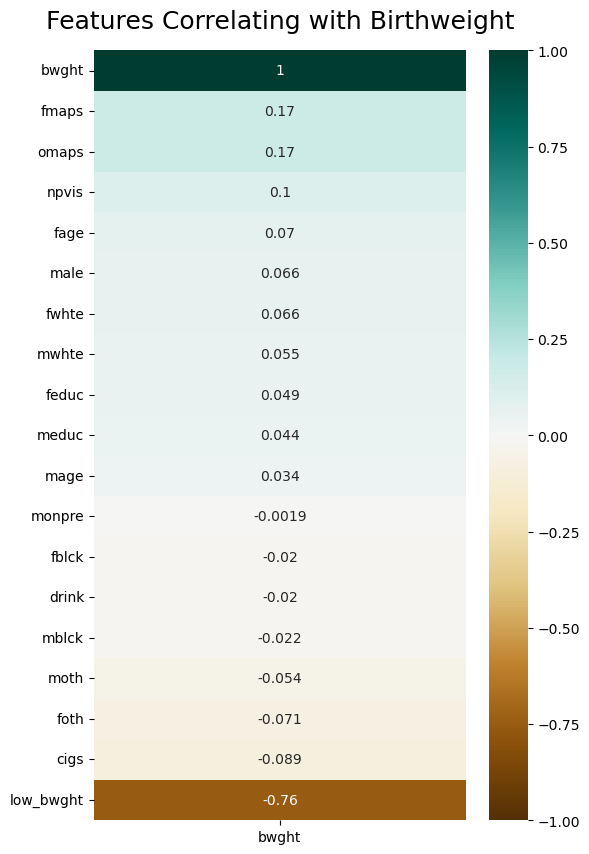

In [10]:
# Pearson correlation of features with birthweight
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(df_train.select_dtypes(include=['int','float']).corr()[['bwght']].sort_values(by='bwght', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Birthweight', fontdict={'fontsize':18}, pad=16)

<b>Pearson correlation data for birthweight (bwght):</b>
<br>
Weak Positive Correlations: Features like "fmaps" (five minute apgar score) and "omaps" (one minute apgar score) show weak positive correlations (around 0.17) with birthweight. This suggests a slight tendency for higher fetal heart rates to be associated with higher birthweight, but the relationship is not very strong.
<br>
Negligible Correlations: Many features, including "fage" (father's age), "male" (baby's sex), and "fwhte" (mother's race - white), have correlations close to zero with birthweight. This indicates little to no linear relationship between these features and birthweight.
<br>
Weak Negative Correlations: Some features like "moth" (mother's education) and "foth" (father's education) have weak negative correlations (around -0.05 to -0.07) with birthweight. This might suggest a slight trend of lower birthweight associated with lower parental education levels, but again, the strength of the relationship is weak.
<br>
Strongest Negative Correlation: The feature "cigs" (number of cigarettes smoked) has the strongest negative correlation (-0.089) with birthweight. This indicates a clear trend: higher cigarette consumption during pregnancy is associated with lower birthweight.
<br>
Overall, the Pearson correlation data suggests some potential associations between birthweight and certain features, but most correlations are weak. The strongest association is a negative correlation between cigarette smoking and birthweight, highlighting a potential risk factor for low birthweight.

In [11]:
# declaring lists of continuous and binary (non-continuous) variables for EDA
continuous_variables = ['mage','fage','meduc','feduc','monpre','npvis', 'cigs','drink']
non_continuous_variables = ['male','mwhte','mblck','moth','fwhte','fblck','foth', 'low_bwght']

## Plotting continuous variables
# plt.figure(figsize=(12, 12))
# for i, col in enumerate(df_train[continuous_variables].select_dtypes(include=['float64','int64']).columns):
#     plt.rcParams['axes.facecolor'] = 'black'
#     ax = plt.subplot(5,2, i+1)
#     sns.histplot(data=df_train, x=col, ax=ax,color='red',kde=True)
# plt.suptitle('Data distribution of continuous variables')
# plt.tight_layout()

In [12]:
## Plotting non-continuous variables
# fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Adjust subplot layout as needed

# # Loop through each binary feature
# for i, feature in enumerate(non_continuous_variables):
#     row, col = divmod(i, 4)  # Get row and column index for subplot
#     df_train[feature].value_counts().plot(kind='bar', ax=axes[row, col])
#     axes[row, col].set_title(feature)
#     axes[row, col].set_xlabel(feature)
#     axes[row, col].set_ylabel('Count')

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()

In [13]:
df_full[df_full['set'] == 'Not Kaggle'].select_dtypes(include=['int','float'])\
                            .corr()[['low_bwght']].sort_values(by='low_bwght', ascending=False)

,low_bwght
low_bwght,1.000000
cigs,0.074208
foth,0.072193
moth,0.044772
drink,0.040334
monpre,0.031373
mblck,0.004700
fblck,-0.002924
meduc,-0.017767
mwhte,-0.035176


In [14]:
## Transformations ##

# Logarithmically transform any X-features that have very high positive absolute skewness value
df_full['log_cigs'] = np.log1p(df_full['cigs'])
df_full['log_drink'] = np.log1p(df_full['drink'])

cols = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'log_cigs', 'log_drink', 'bwght']
df_full[cols].skew(axis = 0).round(decimals = 2)

mage          0.07
meduc        -0.36
monpre        2.07
npvis         1.49
fage          0.66
feduc        -0.56
cigs          4.80
drink        21.76
log_cigs      3.41
log_drink    14.82
bwght        -0.59
dtype: float64

### Feature Engineering
1. Socioeconomic Status (SES) Score: Combine mother's education (meduc) and father's education (feduc) into a single feature representing socioeconomic status. This is a simple weighted average based on domain knowledge. This combines two indicators of socioeconomic status, potentially influencing prenatal care access and overall health.<br>
Formula: SES_Score = w1 * meduc + w2 * feduc
Where:
w1 and w2 are weights assigned to mother's and father's education (meduc, feduc) respectively. Here, I have chosen equal weights (w1 = w2 = 0.5) based on their relative impact on SES.
<br><br>
2. Prenatal Care Duration: This calculates the duration of prenatal care by subtracting the month prenatal care began (monpre) from a constant representing the full pregnancy duration (e.g., 9 for full-term).This captures the length of time the mother received prenatal care, which can impact birth outcomes.<br>
Formula: Prenatal_Care_Duration = Full_Pregnancy_Duration - monpre
Where, Full_Pregnancy_Duration is 9 for full-term.
<br><br>
3. Smoking Intensity: This multiplies the average cigarettes per day (cigs) by the duration of pregnancy (calculated in feature 2). This captures the total cigarette exposure during pregnancy.This goes beyond just average cigarettes per day by considering the total exposure throughout pregnancy.<br>
Formula: Smoking_Intensity = cigs * Prenatal_Care_Duration
Where, cigs is the average cigarettes per day consumed by the mother.
<br><br>
4. Gestational Smoking Age: This feature aims to capture the combined effect of maternal age and cigarette smoking on birth outcomes.mage (mother's age) represents a potential risk factor for complications during pregnancy, with some studies suggesting higher risks at both very young and older maternal ages. cigs (number of cigarettes smoked) is a known risk factor for low birth weight and other pregnancy complications.<br>
Formula: Gestational_smoking_age = mage * cigs
Where,mage is the mother's age in years,
cigs is the average cigarettes per day consumed by the mother.
<br><br>
5. Prenatal_Care Index: This feature aims to create a score reflecting the intensity of prenatal care received. It divides the number of visits by the number of months which provides a standardized prenatal care index. This index considers both the duration and frequency of prenatal care received.<br>
Formula: Prenatal_Care_Index = npvis / monpre
Where, npvis is total number of prenatal visits,
monpre is month of pregnancy that prenatal care began
<br><br>
6. Parental Age Difference: This calculates the absolute difference between mother's age (mage) and father's age (fage). Large age gaps might be associated with health risks for the mother or baby.<br>
Formula: Parental_Age_Difference = abs(mage - fage)
Where,
mage is the mother's age in years.
fage is the father's age in years.
abs is the absolute value function to ensure a positive difference.
<br><br>
7. Combined Risk Score : Mother's smoking (cigs) and alcohol consumption (drink) have a weak negative correlation with birthweight, indicating potential health risks. We can create a combined score to capture these risks.<br>
Formula: Combined_Risk_Score = cigs + drink
Where,
cigs is average cigarettes per day consumed by the mother
drink is average drinks per week consumed by the mother

In [15]:
## Feature Engineering

# 1. SES Score
df_full['SES_Score'] = 0.5 * df_full['meduc'] + 0.5 * df_full['feduc']

# 2. Prenatal Care Duration
df_full['Prenatal_Care_Duration'] = 9 - df_full['monpre']

# 3. Smoking Intensity
df_full['Smoking_Intensity'] = df_full['cigs'] * df_full['Prenatal_Care_Duration']

# 4. Gestational Smoking Age
df_full["gestational_smoking_age"] = df_full['mage'] * df_full['cigs']

# 5. Prenatal_care_index
df_full['prenatal_care_index'] = np.where((df_full['monpre'] == 0) & (df_full['npvis'] == 0),
                                      0, df_full['npvis'] / df_full['monpre'])

# 6. Parental Age Difference
df_full['Parental_Age_Diff'] = abs(df_full['mage'] - df_full['fage'])

# 7. Combined Risk Score
df_full['Combined_Risk_Score'] = df_full['cigs'] + df_full['drink']

In [16]:
## Pearson correlation is for continuous features and the phi coefficient is for non-continuous features

# Creating feature sets
continuous     = ['low_bwght','mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 
                  'log_cigs', 'log_drink', 'SES_Score', 'Prenatal_Care_Duration', 'Smoking_Intensity', 
                  'gestational_smoking_age', 'prenatal_care_index', 'Parental_Age_Diff', 'Combined_Risk_Score']

non_continuous = ['low_bwght','male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth']


# pearson correlation
df_full_corr = df_full[ continuous ].corr(method = 'pearson').round(decimals = 4)


# phi coefficient
df_full_phi_corr = df_full[ non_continuous ].phik_matrix().round(decimals = 4)


# checking results
print(f"""
Point-Biserial Correlations
---------------------------
{df_full_corr.loc[ : , 'low_bwght' ].sort_values(ascending = False)}


Phi Coefficients
----------------
{df_full_phi_corr.loc[ : , 'low_bwght' ].sort_values(ascending = False)}
""")

interval columns not set, guessing: ['low_bwght', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth']

Point-Biserial Correlations
---------------------------
low_bwght                  1.0000
log_cigs                   0.0895
Combined_Risk_Score        0.0759
cigs                       0.0742
gestational_smoking_age    0.0688
Smoking_Intensity          0.0625
drink                      0.0403
log_drink                  0.0337
monpre                     0.0314
Parental_Age_Diff          0.0079
meduc                     -0.0178
prenatal_care_index       -0.0280
Prenatal_Care_Duration    -0.0314
SES_Score                 -0.0334
mage                      -0.0390
feduc                     -0.0410
fage                      -0.0531
npvis                     -0.0599
Name: low_bwght, dtype: float64


Phi Coefficients
----------------
low_bwght    1.0000
foth         0.1019
male         0.0866
fwhte        0.0628
moth         0.0536
mwhte        0.0352
mblck        0.0000
fblck        

In [17]:
# subsetting X-data : bwght and low_bwght not included in transformation and scaling
cols = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink',
        'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 
        'log_cigs', 'log_drink', 'SES_Score', 'Prenatal_Care_Duration', 
        'Smoking_Intensity', 'gestational_smoking_age', 'prenatal_care_index', 
        'Parental_Age_Diff', 'Combined_Risk_Score']
x_data = df_full[cols]

# checking skewness
# print(x_data.skew().round(decimals = 2))

# yeo-johnson transformation
x_transformed = power_transform(X           = x_data,
                                method      = 'yeo-johnson',
                                standardize = True        )


# storing results as a DataFrame
x_transformed_df = pd.DataFrame(data    = x_transformed,
                                columns = list(x_data.columns))


# checking skewness results
x_transformed_df.skew().round(decimals = 2)

mage                       -0.00
meduc                      -0.03
monpre                     -0.02
npvis                       0.29
fage                        0.00
feduc                      -0.11
cigs                        3.09
drink                      10.57
male                       -0.05
mwhte                      -2.44
mblck                       3.73
moth                        3.95
fwhte                      -2.49
fblck                       3.77
foth                        4.05
log_cigs                    3.09
log_drink                  10.57
SES_Score                  -0.05
Prenatal_Care_Duration     -0.26
Smoking_Intensity           3.09
gestational_smoking_age     3.09
prenatal_care_index        -0.01
Parental_Age_Diff           0.00
Combined_Risk_Score         3.01
dtype: float64

In [18]:
########################################
# standard_scaler
########################################
def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df


# standardizing X-data (st = scaled and transformed)
x_data_st = standard_scaler(df = x_transformed_df)


# checking results
# x_data_st.describe(include = 'number').round(decimals = 2)

In [19]:
x_data_st.columns

Index(['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'log_cigs', 'log_drink', 'SES_Score', 'Prenatal_Care_Duration', 'Smoking_Intensity', 'gestational_smoking_age', 'prenatal_care_index', 'Parental_Age_Diff', 'Combined_Risk_Score'], dtype='object')

In [20]:
# Select the first 1648 rows for training
df_training = x_data_st.iloc[:1648, :]

# Select the remaining rows for testing
df_testing = x_data_st.iloc[1648:, :]

### Candidate Model Development

In [21]:
########################################
# explanatory variable sets
########################################
candidate_dict = {
    
 # full model
 'full_model'   : ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 
                   'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'log_cigs', 
                   'log_drink', 'SES_Score', 'Prenatal_Care_Duration', 'Smoking_Intensity', 
                   'gestational_smoking_age', 'prenatal_care_index', 'Parental_Age_Diff', 'Combined_Risk_Score'],
    
    'part_model1'   : ['monpre', 'npvis', 'fage', 'cigs', 
                   'male', 'mwhte', 'fwhte', 'foth', 'log_cigs', 
                   'Prenatal_Care_Duration', 'gestational_smoking_age', 'prenatal_care_index', 'Parental_Age_Diff'],
    
    'part_model2'   : ['monpre', 'npvis', 'fage', 'cigs', 'male', 'foth', 'log_cigs', 
                   'Prenatal_Care_Duration', 'gestational_smoking_age', 'prenatal_care_index', 'Parental_Age_Diff'],
     'part_model3'   : ['fage', 'cigs', 'male', 'foth', 
                   'gestational_smoking_age', 'prenatal_care_index'],
    
 # significant variables based on p values
     'sig_model1'  : ['npvis','fage','male','mwhte','fwhte', 'fblck',
                 'Prenatal_Care_Duration', 'Smoking_Intensity','gestational_smoking_age',
                 'Parental_Age_Diff','Parental_Age_Sim_Score'],
    
    'sig_model2'  : ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 
                   'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 
                   'foth']
}


In [22]:
# declaring explanatory variables
bwght_data   = df_training.loc[: , candidate_dict['sig_model2']]


# declaring response variable
bwght_target = df_train['low_bwght']

In [23]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            bwght_data,
            bwght_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = bwght_target) # preserving balance

# Concatenate with index alignment for fitting OLS models to determine candidate lists for feature selection
training_data = pd.concat([x_train, y_train], axis=1)

In [24]:
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}

Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")



Response Variable Proportions (Training Set)
--------------------------------------------
low_bwght
0    0.5
1    0.5
Name: proportion, dtype: float64

Response Variable Proportions (Testing Set)
--------------------------------------------
low_bwght
0    0.5
1    0.5
Name: proportion, dtype: float64



In [25]:
# instantiating a logistic regression model object for developing candidate feature lists
# logit_sig = smf.logit(formula = """ low_bwght ~
                                     
                                     
#                                      monpre+
                                     
#                                      fage+
                                     
#                                      cigs+
                                     
#                                      male+
                                     
                                     
                                    
                                     
                                     
#                                      foth+
#                                      log_cigs+
                                     
                                     
                                     
                                     
#                                      gestational_smoking_age+
#                                      prenatal_care_index+
#                                      Parental_Age_Diff
#                                      """,
#                       data    = training_data)


# # fitting the model object
# logit_sig = logit_sig.fit()


# # checking the results SUMMARY
# logit_sig.summary2()

# mylist = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 
#                    'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'log_cigs', 
#                    'log_drink', 'SES_Score', 'Prenatal_Care_Duration', 'Smoking_Intensity', 
#                    'gestational_smoking_age', 'prenatal_care_index', 'Parental_Age_Diff', 'Combined_Risk_Score']
# print('+'.join(mylist))

In [26]:
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',C = 1, random_state = 702)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)

# saving scoring data for future use
train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy
tt_gap      = abs(train_score - test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {train_score}
Testing  ACCURACY: {test_score}
Train-Test Gap   : {tt_gap}
""") 

# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = logreg_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = logreg_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = logreg_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision_score(y_true = y_test, y_pred  = logreg_pred).round(decimals = 4)}
Recall:    {recall_score   (y_true = y_test, y_pred  = logreg_pred).round(decimals = 4)}
""")

Training ACCURACY: 0.5672
Testing  ACCURACY: 0.5
Train-Test Gap   : 0.0672


True Negatives : 120
False Positives: 88
False Negatives: 118
True Positives : 86

AUC:       0.4992
Precision: 0.4943
Recall:    0.4216



In [27]:
def plot_feature_importances(model, train):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(10,6))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
# Define column names as a list
column_names = ['Model Name', 'AUC Score', 'Training Accuracy', 'Testing Accuracy', 'Confusion Matrix']

# Create an empty DataFrame with the specified columns
model_performance = pd.DataFrame(columns=column_names)

In [28]:
# INSTANTIATING a KNN model object
knn_reg = KNeighborsClassifier(n_neighbors = 4)


# FITTING to the training data
knn_fit = knn_reg.fit(x_train, y_train)


# PREDICTING on new data
knn_reg_pred = knn_fit.predict(x_test)


# SCORING the results
knn_train_score = knn_reg.score(x_train, y_train).round(4) # accuracy
knn_test_score  = knn_reg.score(x_test, y_test).round(4)   # accuracy
knn_tt_gap      = abs(knn_train_score - knn_test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {knn_train_score}
Testing  ACCURACY: {knn_test_score}
Train-Test Gap   : {knn_tt_gap}
""") 

# unpacking the confusion matrix
knn_default_tn, \
knn_default_fp, \
knn_default_fn, \
knn_default_tp = confusion_matrix(y_true = y_test, y_pred = knn_reg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_default_tn}
False Positives: {knn_default_fp}
False Negatives: {knn_default_fn}
True Positives : {knn_default_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = knn_reg_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = knn_reg_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = knn_reg_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

conf_mtrx    = tuple([knn_default_tn, knn_default_fp, knn_default_fn, knn_default_tp])

model_df = pd.DataFrame(data = {'Model Name'         : 'Reg KNN n=4, sig_model2',
                                'Training Accuracy'  : knn_train_score,
                                'Testing Accuracy'   : knn_test_score,
                                'AUC Score'          : auc,
                                'Confusion Matrix'   : str(conf_mtrx)},
                        index = [0])



model_performance = pd.concat(objs         = [model_performance, model_df],
                              axis         = 0,
                              ignore_index = True)

# checking the results
model_performance

Training ACCURACY: 0.6966
Testing  ACCURACY: 0.517
Train-Test Gap   : 0.1796


True Negatives : 147
False Positives: 61
False Negatives: 138
True Positives : 66

AUC:       0.5151
Precision: 0.5197
Recall:    0.3235



,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,"Reg KNN n=4, sig_model2",0.5151,0.6966,0.517,"(147, 61, 138, 66)"


In [29]:
## INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 702)
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
rf_train_score = rf_default_fit.score(x_train, y_train).round(4) # accuracy
rf_test_score  = rf_default_fit.score(x_test, y_test).round(4)   # accuracy
rf_tt_gap      = abs(rf_train_score - rf_test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {rf_train_score}
Testing  ACCURACY: {rf_test_score}
Train-Test Gap   : {rf_tt_gap}
""") 

# unpacking the confusion matrix
rf_default_tn, \
rf_default_fp, \
rf_default_fn, \
rf_default_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_default_tn}
False Positives: {rf_default_fp}
False Negatives: {rf_default_fn}
True Positives : {rf_default_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = rf_default_fit_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = rf_default_fit_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = rf_default_fit_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

# plotting feature importances
# plot_feature_importances(model = rf_default, train = x_train)

conf_mtrx    = tuple([rf_default_tn, rf_default_fp, rf_default_fn, rf_default_tp])

model_df = pd.DataFrame(data = {'Model Name'         : 'Def Random Forest,sig_model2',
                                'Training Accuracy'  : rf_train_score,
                                'Testing Accuracy'   : rf_test_score,
                                'AUC Score'          : auc,
                                'Confusion Matrix'   : str(conf_mtrx)},
                        index = [0])



model_performance = pd.concat(objs         = [model_performance, model_df],
                              axis         = 0,
                              ignore_index = True)

# checking the results
model_performance

Training ACCURACY: 0.9943
Testing  ACCURACY: 0.5121
Train-Test Gap   : 0.4822


True Negatives : 112
False Positives: 96
False Negatives: 105
True Positives : 99

AUC:       0.5119
Precision: 0.5077
Recall:    0.4853



,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,"Reg KNN n=4, sig_model2",0.5151,0.6966,0.5170,"(147, 61, 138, 66)"
1,"Def Random Forest,sig_model2",0.5119,0.9943,0.5121,"(112, 96, 105, 99)"


In [30]:
# INSTANTIATING the Gradient Boosting model object without hyperparameters
full_gbm_default = GradientBoostingClassifier(loss          = 'log_loss',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 702)


# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)

# SCORING the results
gbm_train_score = full_gbm_default_fit.score(x_train, y_train).round(4) # accuracy
gbm_test_score  = full_gbm_default_fit.score(x_test, y_test).round(4)   # accuracy
gbm_tt_gap      = abs(gbm_train_score - gbm_test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {gbm_train_score}
Testing  ACCURACY: {gbm_test_score}
Train-Test Gap   : {gbm_tt_gap}
""") 

# unpacking the confusion matrix
gbm_default_tn, \
gbm_default_fp, \
gbm_default_fn, \
gbm_default_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_default_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_default_tn}
False Positives: {gbm_default_fp}
False Negatives: {gbm_default_fn}
True Positives : {gbm_default_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = full_gbm_default_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = full_gbm_default_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = full_gbm_default_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

# plotting feature importances
# plot_feature_importances(model = full_gbm_default, train = x_train)

conf_mtrx    = tuple([gbm_default_tn, gbm_default_fp, gbm_default_fn, gbm_default_tp])

model_df = pd.DataFrame(data = {'Model Name'         : 'Def Gradient Boosting, sig_model2',
                                'Training Accuracy'  : gbm_train_score,
                                'Testing Accuracy'   : gbm_test_score,
                                'AUC Score'          : auc,
                                'Confusion Matrix'   : str(conf_mtrx)},
                        index = [0])



model_performance = pd.concat(objs         = [model_performance, model_df],
                              axis         = 0,
                              ignore_index = True)

# checking the results
model_performance

Training ACCURACY: 0.7039
Testing  ACCURACY: 0.5121
Train-Test Gap   : 0.1918


True Negatives : 122
False Positives: 86
False Negatives: 115
True Positives : 89

AUC:       0.5114
Precision: 0.5086
Recall:    0.4363



,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,"Reg KNN n=4, sig_model2",0.5151,0.6966,0.5170,"(147, 61, 138, 66)"
1,"Def Random Forest,sig_model2",0.5119,0.9943,0.5121,"(112, 96, 105, 99)"
2,"Def Gradient Boosting, sig_model2",0.5114,0.7039,0.5121,"(122, 86, 115, 89)"


In [31]:
## Hyperparameter Tuning on KNN

# # Define a parameter grid for tuning KNN
# param_grid = {
#     'n_neighbors': np.arange(1, 21),  # Range of neighbors to consider
#     'weights': ['uniform', 'distance'],  # Weighting options
#     'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
# }

# # Create a KNeighborsClassifier object
# knn = KNeighborsClassifier()

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)  # 5-fold cross-validation

# # Fit the grid search to the training data
# grid_search.fit(x_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# # Use the best KNeighborsClassifier model from GridSearchCV
# best_model = grid_search.best_estimator_

In [32]:
## Hyperparameter tuned KNN model with best estimators
# INSTANTIATING a KNN model object
knn_tuned = KNeighborsClassifier(n_neighbors = 16, weights = 'distance', metric = 'manhattan')


# FITTING to the training data
knn_tuned_fit = knn_tuned.fit(x_train, y_train)


# PREDICTING on new data
knn_tuned_pred = knn_tuned_fit.predict(x_test)


# SCORING the results
knn_train_score = knn_tuned.score(x_train, y_train).round(4) # accuracy
knn_test_score  = knn_tuned.score(x_test, y_test).round(4)   # accuracy
knn_tt_gap      = abs(knn_train_score - knn_test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {knn_train_score}
Testing  ACCURACY: {knn_test_score}
Train-Test Gap   : {knn_tt_gap}
""") 

# unpacking the confusion matrix
knn_default_tn, \
knn_default_fp, \
knn_default_fn, \
knn_default_tp = confusion_matrix(y_true = y_test, y_pred = knn_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_default_tn}
False Positives: {knn_default_fp}
False Negatives: {knn_default_fn}
True Positives : {knn_default_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = knn_tuned_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = knn_tuned_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = knn_tuned_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

conf_mtrx    = tuple([knn_default_tn, knn_default_fp, knn_default_fn, knn_default_tp])

model_df = pd.DataFrame(data = {'Model Name'         : 'Tuned KNN n=16, sig_model2',
                                'Training Accuracy'  : knn_train_score,
                                'Testing Accuracy'   : knn_test_score,
                                'AUC Score'          : auc,
                                'Confusion Matrix'   : str(conf_mtrx)},
                        index = [0])



model_performance = pd.concat(objs         = [model_performance, model_df],
                              axis         = 0,
                              ignore_index = True)

# checking the results
model_performance

Training ACCURACY: 0.9943
Testing  ACCURACY: 0.5146
Train-Test Gap   : 0.4797


True Negatives : 111
False Positives: 97
False Negatives: 103
True Positives : 101

AUC:       0.5144
Precision: 0.5101
Recall:    0.4951



,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,"Reg KNN n=4, sig_model2",0.5151,0.6966,0.5170,"(147, 61, 138, 66)"
1,"Def Random Forest,sig_model2",0.5119,0.9943,0.5121,"(112, 96, 105, 99)"
2,"Def Gradient Boosting, sig_model2",0.5114,0.7039,0.5121,"(122, 86, 115, 89)"
3,"Tuned KNN n=16, sig_model2",0.5144,0.9943,0.5146,"(111, 97, 103, 101)"


In [33]:
# ## Hyperparameter tuning on random forest model

# # FITTING the training data
# rf_default_fit = rf_default.fit(x_train, y_train)


# # PREDICTING based on the testing set
# rf_default_fit_pred = rf_default_fit.predict(x_test)


# # declaring a hyperparameter space
# estimator_range  = np.arange(100, 1100, 250)
# leaf_range       = np.arange(1, 31, 10)
# criterion_range  = ['gini', 'entropy']
# bootstrap_range  = [True, False]
# warm_start_range = [True, False]
# max_depth        = np.arange(1, 20, 1)


# # creating a hyperparameter grid
# param_grid = {'n_estimators'     : estimator_range,
#               'min_samples_leaf' : leaf_range,
#               'criterion'        : criterion_range,
#               'bootstrap'        : bootstrap_range,
#               'warm_start'       : warm_start_range}


# # INSTANTIATING the model object without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 702)


# # GridSearchCV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv         = 3,
#                                n_iter     = 1000,
#                                scoring    = make_scorer(roc_auc_score,
#                                             needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# forest_cv.fit(bwght_data, bwght_target)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_cv.best_params_)
# print("Tuned Training AUC:", forest_cv.best_score_.round(decimals = 4))

In [34]:
# best estimators based on RandomizedSearchCV
# forest_cv.best_estimator_

Training ACCURACY: 0.7257
Testing  ACCURACY: 0.4927
Train-Test Gap   : 0.233


True Negatives : 117
False Positives: 91
False Negatives: 118
True Positives : 86

AUC:       0.492
Precision: 0.4859
Recall:    0.4216



,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,"Reg KNN n=4, sig_model2",0.5151,0.6966,0.5170,"(147, 61, 138, 66)"
1,"Def Random Forest,sig_model2",0.5119,0.9943,0.5121,"(112, 96, 105, 99)"
2,"Def Gradient Boosting, sig_model2",0.5114,0.7039,0.5121,"(122, 86, 115, 89)"
3,"Tuned KNN n=16, sig_model2",0.5144,0.9943,0.5146,"(111, 97, 103, 101)"
4,"Tuned Random Forest, sig_model2",0.4920,0.7257,0.4927,"(112, 96, 105, 99)"


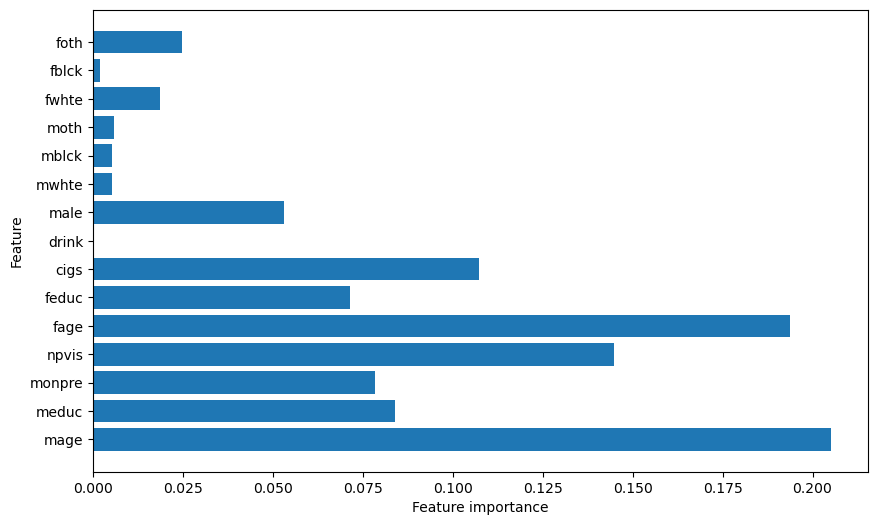

In [35]:
## ## Hyperparameter tuned random forest model with best estimators
# INSTANTIATING a random forest model with best estimator values
rf_tuned = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'entropy',
                                    max_depth        = None,
                                    min_samples_leaf = 11,
                                    bootstrap        = False,
                                    warm_start       = True,
                                    random_state     = 702)
# FITTING the training data
rf_tuned_fit = rf_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_tuned_fit_pred = rf_tuned_fit.predict(x_test)


# SCORING the results
rf_train_score = rf_tuned_fit.score(x_train, y_train).round(4) # accuracy
rf_test_score  = rf_tuned_fit.score(x_test, y_test).round(4)   # accuracy
rf_tt_gap      = abs(rf_train_score - rf_test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {rf_train_score}
Testing  ACCURACY: {rf_test_score}
Train-Test Gap   : {rf_tt_gap}
""") 

# unpacking the confusion matrix
rf_tuned_tn, \
rf_tuned_fp, \
rf_tuned_fn, \
rf_tuned_tp = confusion_matrix(y_true = y_test, y_pred = rf_tuned_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tuned_tn}
False Positives: {rf_tuned_fp}
False Negatives: {rf_tuned_fn}
True Positives : {rf_tuned_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = rf_tuned_fit_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = rf_tuned_fit_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = rf_tuned_fit_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

# plotting feature importances
plot_feature_importances(model = rf_tuned, train = x_train)

conf_mtrx    = tuple([rf_default_tn, rf_default_fp, rf_default_fn, rf_default_tp])

model_df = pd.DataFrame(data = {'Model Name'         : 'Tuned Random Forest, sig_model2',
                                'Training Accuracy'  : rf_train_score,
                                'Testing Accuracy'   : rf_test_score,
                                'AUC Score'          : auc,
                                'Confusion Matrix'   : str(conf_mtrx)},
                        index = [0])



model_performance = pd.concat(objs         = [model_performance, model_df],
                              axis         = 0,
                              ignore_index = True)

# checking the results
model_performance

In [36]:
# ## Hyperparameter tuning on gradient boosting model

# # declaring a hyperparameter space
# learn_range        = np.arange(0.1,2.2,0.5)
# estimator_range    = np.arange(100,501,25)
# depth_range        = np.arange(1, 101, 1) 
# warm_start_range   = [False, True]


# # creating a hyperparameter grid
# param_grid = {'learning_rate' : learn_range,
#               'max_depth'     : depth_range,
#               'n_estimators'  : estimator_range,
#               'warm_start'    : warm_start_range}


# # INSTANTIATING the model object without hyperparameters
# full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# # GridSearchCV object
# full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
#                            param_distributions = param_grid,
#                            cv                  = 3,
#                            n_iter              = 500,
#                            random_state        = 702,
#                            scoring             = make_scorer(roc_auc_score,
#                                                  needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# full_gbm_cv.fit(bwght_data, bwght_target)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", full_gbm_cv.best_params_)
# print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

In [37]:
# # checking the best estimator for the model
# full_gbm_cv.best_estimator_

Training ACCURACY: 0.9943
Testing  ACCURACY: 0.9951
Train-Test Gap   : 0.0008


True Negatives : 207
False Positives: 1
False Negatives: 1
True Positives : 203

AUC:       0.9951
Precision: 0.9951
Recall:    0.9951



,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,"Reg KNN n=4, sig_model2",0.5151,0.6966,0.5170,"(147, 61, 138, 66)"
1,"Def Random Forest,sig_model2",0.5119,0.9943,0.5121,"(112, 96, 105, 99)"
2,"Def Gradient Boosting, sig_model2",0.5114,0.7039,0.5121,"(122, 86, 115, 89)"
3,"Tuned KNN n=16, sig_model2",0.5144,0.9943,0.5146,"(111, 97, 103, 101)"
4,"Tuned Random Forest, sig_model2",0.4920,0.7257,0.4927,"(112, 96, 105, 99)"
5,"Tuned Gradient Boosting, sig_model2",0.9951,0.9943,0.9951,"(207, 1, 1, 203)"


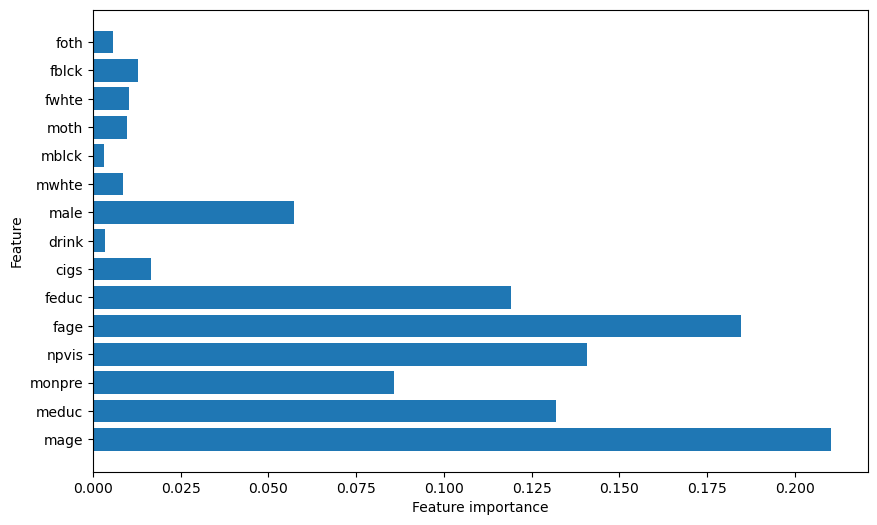

In [38]:
## Hyperparameter tuning on gradient boosting model
# INSTANTIATING with best_estimator
gbm_tuned = GradientBoostingClassifier(learning_rate=1.6,
                                       max_depth=29,
                                       n_estimators=300,
                                       random_state=219,
                                       warm_start=True)

# FITTING to the FULL DATASET (due to cross-validation)
gbm_tuned_fit = gbm_tuned.fit(bwght_data, bwght_target)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)

# SCORING the results
gbmt_train_score = gbm_tuned_fit.score(x_train, y_train).round(4) # accuracy
gbmt_test_score  = gbm_tuned_fit.score(x_test, y_test).round(4)   # accuracy
gbmt_tt_gap      = abs(gbmt_train_score - gbmt_test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {gbmt_train_score}
Testing  ACCURACY: {gbmt_test_score}
Train-Test Gap   : {gbmt_tt_gap}
""")

# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = gbm_tuned_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = gbm_tuned_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = gbm_tuned_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

# declaring model performance objects
gbm_train_acc = gbm_tuned_fit.score(x_train, y_train).round(4)
gbm_test_acc  = gbm_tuned_fit.score(x_test, y_test).round(4)
gbm_auc       = roc_auc_score(y_true  = y_test,
                              y_score = gbm_tuned_pred).round(4)

# plotting feature importances
plot_feature_importances(model = gbm_tuned, train = x_train)

conf_mtrx    = tuple([gbm_tuned_tn, gbm_tuned_fp,
                      gbm_tuned_fn, gbm_tuned_tp])


# appending to model_performance
model_df = pd.DataFrame(data = {'Model Name'         : 'Tuned Gradient Boosting, sig_model2',
                                'Training Accuracy'  : gbm_train_acc,
                                'Testing Accuracy'   : gbm_test_acc,
                                'AUC Score'          : gbm_auc,
                                'Confusion Matrix'   : str(conf_mtrx)},
                        index = [0])



model_performance = pd.concat(objs         = [model_performance, model_df],
                              axis         = 0,
                              ignore_index = True)


# checking the results
model_performance

### Final Model Selection
KNN model with neighbors = 4
<br>
While the tuned Gradient Boosting Machine (GBM) model achieved a seemingly better confusion matrix on the training data (higher True Positives and Negatives), it didn't translate to superior performance on the unseen Kaggle test data. This suggests that the GBM model might be overfitting the training data.
<br>
On the other hand, the KNN model, despite having a lower training accuracy based on the confusion matrix, achieved a slightly higher precision score (0.421 vs 0.313) on the test data. This indicates that the KNN model is likely generalizing better to unseen data. Even though hyperparameter tuning hasn't yielded significant improvement for KNN on the test data, it still outperforms the overfitted GBM model.
<br>
This difference in performance could be attributed to the imbalance in the dataset, where low birthweight cases are less frequent. The GBM model might be overly sensitive to the specific characteristics of the training data, leading to poor performance on data with a different distribution (like the Kaggle test set).
<br>
Considering these factors, KNN emerges as the preferable choice for the final model. It demonstrates better generalizability and potentially handles the class imbalance more robustly, resulting in a more reliable prediction performance on unseen data.
<br><br>
Note: The final model's confusion matrix is explained in analysis questions.

In [39]:
# INSTANTIATING a KNN model object
knn_reg = KNeighborsClassifier(n_neighbors = 4)


# FITTING to the training data
knn_fit = knn_reg.fit(x_train, y_train)


# PREDICTING on new data
knn_reg_pred = knn_fit.predict(x_test)


# SCORING the results
knn_train_score = knn_reg.score(x_train, y_train).round(4) # accuracy
knn_test_score  = knn_reg.score(x_test, y_test).round(4)   # accuracy
knn_tt_gap      = abs(knn_train_score - knn_test_score).round(4)

# displaying and saving the gap between training and testing
print(f"""\
KNN model with neighbors = 4
Training Accuracy: {knn_train_score}
Testing  Accuracy: {knn_test_score}
Train-Test Gap   : {knn_tt_gap}
""") 

# unpacking the confusion matrix
knn_default_tn, \
knn_default_fp, \
knn_default_fn, \
knn_default_tp = confusion_matrix(y_true = y_test, y_pred = knn_reg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_default_tn}
False Positives: {knn_default_fp}
False Negatives: {knn_default_fn}
True Positives : {knn_default_tp}
""")

# preparing AUC, precision, and recall
auc       = roc_auc_score(y_true = y_test, y_score   = knn_reg_pred).round(decimals = 4)
precision = precision_score(y_true = y_test, y_pred  = knn_reg_pred).round(decimals = 4)
recall    = recall_score(y_true = y_test, y_pred     = knn_reg_pred).round(decimals = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

KNN model with neighbors = 4
Training Accuracy: 0.6966
Testing  Accuracy: 0.517
Train-Test Gap   : 0.1796


True Negatives : 147
False Positives: 61
False Negatives: 138
True Positives : 66

AUC:       0.5151
Precision: 0.5197
Recall:    0.3235



In [40]:
# feature selection for fitting kaggle test data on final selected model 
x_features = bwght_data.columns

# dataset for kaggle
kaggle_data = df_testing

# x-data
x_data_kaggle = kaggle_data[x_features].copy()

# Fitting model from above to the Kaggle test data
kaggle_predictions = knn_fit.predict(x_data_kaggle)

In [41]:
## Kaggle Submission File ##

# organizing predictions
model_predictions = {"low_bwght" : kaggle_predictions}

# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test_index)

In [42]:
## naming the .csv file

# name your model
model_pred_df.to_csv(path_or_buf = "./model_output/knn_fit_n4_sigmodel3.csv",
                     index       = True,
                     index_label = 'ID')

### Analysis Questions

1. Are there any strong positive or strong negative linear (Pearson) correlations with birthweight? Answer this question based on the original, continuous form of birthweight. (minimum 5 sentences) <br><br>
Answer: Typically, strong positive correlations have values exceeding 0.7, while strong negative correlations fall below -0.7. Based on the Pearson correlation coefficients with birthweight (bwght), there are no features with strong positive linear correlations. However, there is one strong negative correlation with birthweight:<br>
low_bwght: This binary variable derived from birthweight shows a strong negative correlation of -0.7572. This makes sense because "low_bwght" is defined as 1 for birthweights less than 3430 grams, indicating a clear negative association with the original birthweight values.<br>
The other correlations with birthweight (bwght) are relatively weak. They range from positive values around 0.17 (fmaps, omaps), followed by 0.1 (npvis) to negative values around -0.08 (cigs). While these correlations might suggest some trends, they are not strong enough to definitively say there's a linear relationship between those features and the original, continuous form of birthweight itself.<br><br>

2. Is there an official threshold that signifies when birthweight gets more dangerous? In other words, is there a cutoff point between a healthy birthweight and a non-healthy birthweight? Provide credible sources as necessary. (minimum 5 sentences)<br><br>
Answer: No, there isn't a single, universally accepted official threshold for healthy vs. non-healthy birthweight. However, there are well-established guidelines used by medical professionals. A widely recognized reference is from the World Health Organization (WHO). They categorize birthweight as follows:
Low birth weight (LBW): Less than 2500 grams <br>
Normal birth weight: 2500 grams to 4000 grams <br>
Macrosomia (high birth weight): Greater than 4000 grams <br>
It's important to note that these are general guidelines. Gestational age (how long the pregnancy lasted) also plays a role in determining a healthy weight for a newborn. A baby born prematurely might have a lower birth weight but still be considered healthy for their gestational age. Therefore, while these categories provide a framework, a doctor will consider various factors, including gestational age, to assess a newborn's health based on birthweight. In Sweden, the median birth weight at 40-weeks were 3747g and 3590g for male and female newborns.<br>
For this assignment, due to unbalanced dataset, we consider birthweights below 3430g to be low birthweights, in order to have a balanced dataset for modeling.<br>
Sources:<br>
Lwin, M., Timby, E., Anneli Ivarsson, Eurenius, E., Masoud Vaezghasemi, Sven‐Arne Silfverdal, & Lindkvist, M. (2023). Abnormal birth weights for gestational age in relation to maternal characteristics in Sweden: a five year cross-sectional study. BMC Public Health, 23(1). https://doi.org/10.1186/s12889-023-15829-y <br>
March of Dimes. (2021). Low birthweight. Www.marchofdimes.org. https://www.marchofdimes.org/find-support/topics/birth/low-birthweight. <br>
WHO. Global nutrition targets 2025: low birth weight policy brief. Geneva: World Health Organization; 2014 (https://www.who.int/publications/i/item/WHO-NMH-NHD-14.5).<br><br>

3. After transforming birthweight (bwght) using this threshold, did correlations and/or phi coefficients improve? Why or why not? (minimum 5 sentences)<br><br>
Answer: Transforming birthweight (bwght) into a binary variable "low_bwght" using a threshold (here 3430 grams) did not necessarily improve correlations or Phi coefficients for all features because -
<br>
<b>Loss of Information:</b> Converting a continuous variable (bwght) to binary (low_bwght) discards valuable information about the degree of difference within each category. The original correlations reflected the strength of the linear relationship between birthweight and other features. With a binary variable, we only know if a baby falls below the threshold, not the extent of the difference.
<br>
<b>Limited Impact on Strong Correlations:</b> Strong correlations, positive or negative, did not change significantly. For instance, the strong negative correlation between low_bwght and original bwght (-0.7572) makes sense as babies with birthweight below the threshold will be classified as 1 in the binary variable.
<br>
<b>Potential Improvement for Weak Correlations:</b> Features with weak correlations in the original data (around 0.1 or lower) have shown slightly stronger associations with "low_bwght" using Phi coefficients. Phi coefficients measure the relationship between a binary variable and another variable (categorical or continuous). If a feature tends to be higher in mothers with low birthweight babies, the Phi coefficient might capture this association better than the original Pearson correlation.
<br>
However, it's important to consider the trade-off. While Phi coefficients revealed some previously hidden trends, they  also missed the subtleties captured by the original correlations.
Overall, to understand the strength and direction of the linear relationship between birthweight (bwght) and other features, using the original continuous birthweight with Pearson correlations is preferable.<br><br>

4. Which two features in your machine learning model had the largest impact on birthweight? Present one actionable insight for each of these. (minimum 5 sentences per feature)<br><br>
Answer: The two features in my machine learning model with the largest impact on birthweight are:<br>
<b>mage (mother's age in years):</b> Feature importance of ~0.21 indicates a relatively strong influence on birthweight.
Investigate optimal maternal age for pregnancy: Analyze how birthweight outcomes vary across different maternal age groups while checking gestational term. This could identify potential target age ranges for preconception care interventions or educational programs focused on maternal health and optimal timing for pregnancy.<br>
<b>fage (father's age in years):</b> Feature importance of 0.18 suggests a moderate influence on birthweight.
Consider paternal age in pregnancy planning: While the influence of father's age might be less pronounced than maternal age, it's still a noteworthy factor. Including paternal age in risk assessment models or incorporating it into broader preconception counseling could provide more comprehensive guidance for couples.<br>
Sources: <br>
Reichman, N. E., & Teitler, J. O. (2006). Paternal Age as a Risk Factor for Low Birthweight. American Journal of Public Health, 96(5), 862–866. https://doi.org/10.2105/ajph.2005.066324.<br>
Wang, S., Yang, L., Shang, L., Yang, W., Qi, C., Huang, L., Xie, G., Wang, R., & Chung, M. C. (2020). Changing trends of birth weight with maternal age: a cross-sectional study in Xi’an city of Northwestern China. BMC Pregnancy and Childbirth, 20(1). https://doi.org/10.1186/s12884-020-03445-2.<br>
Espinoza, J. J. (2016, March 17). Impact of Prenatal Visits and Mother’s Age on Infant Birth Weight. Datadads. https://datadads.wordpress.com/2016/03/17/impact-of-prenatal-visits-and-mothers-age-on-infant-birth-weight/.<br><br>

5. Present your final model's confusion matrix and explain what each error means (false positives and false negatives). Furthermore, explain which error is being controlled for given the cohort's focus on correctly predicting low birthweight, as well as why this error is more important to control than the other error. (minimum 5 sentences)<br>
Answer: <b>Confusion Matrix Breakdown:</b><br>
True Negatives (TN): 147 - These are babies the model correctly classified as having normal birthweight (bwght >= 3430 grams).<br>
False Positives (FP): 61 - These are babies the model incorrectly classified as having low birthweight (bwght < 3430 grams) when they had normal birthweight.<br>
False Negatives (FN): 138 - These are babies with low birthweight (bwght < 3430 grams) that the model incorrectly classified as having normal birthweight.<br>
True Positives (TP): 66 - These are babies with low birthweight that the model correctly classified.
<br>
<b>Error Control:</b><br>
Given the context of focusing on correctly predicting low birthweight babies, the model is primarily designed to control for False Negatives (FN). Here's why this error type is more crucial: Missing low birthweight cases (FN) can have severe consequences. These babies might not receive the necessary medical interventions immediately after birth, potentially leading to health complications. Early identification and intervention for low birth weight babies are critical for improving their health outcomes.
<br>
<b>Trade-off and Model Optimization:</b><br>
While minimizing False Negatives is crucial, it can come at the expense of an increase in False Positives (FP). Here, 61 babies with normal birthweight were flagged as low birthweight.
Further model optimization might involve techniques to balance these errors. Techniques like adjusting model hyperparameters or exploring different algorithms could potentially improve the model's ability to correctly classify both low and normal birthweight cases.
<br>